In [ ]:
import cv2
import matplotlib.pyplot as plt


In [ ]:
IMG_SIZE = 100
new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show()

NameError: ignored

In [ ]:

from keras.models import Sequential, load_model


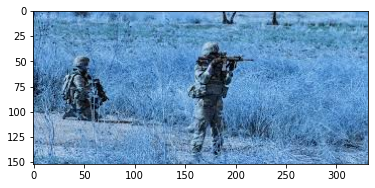

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm

DATADIR = "/content/drive/MyDrive/Colab Notebooks/Manthan/DATSET/training_set"

CATEGORIES = ["terror", "person"]

for category in CATEGORIES:  
    path = os.path.join(DATADIR,category)  
    for img in os.listdir(path):  
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_COLOR)  # convert to array
        plt.imshow(img_array, cmap='gray')  # graph it
        plt.show()  # display!

        break  # we just want one for now so break
    break  #...and one more!

In [ ]:



training_data = []

def create_training_data():
    for category in CATEGORIES:  # do dogs and cats

        path = os.path.join(DATADIR,category)
        class_num = CATEGORIES.index(category)  

        for img in tqdm(os.listdir(path)):
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_training_data()

print(len(training_data))


100%|██████████| 272/272 [01:54<00:00,  2.38it/s] 

649


In [ ]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)

print(X[0].reshape(-1, IMG_SIZE, IMG_SIZE, 1))

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

[[[[122]
   [142]
   [140]
   ...
   [174]
   [169]
   [173]]

  [[108]
   [148]
   [156]
   ...
   [171]
   [171]
   [170]]

  [[ 89]
   [154]
   [162]
   ...
   [177]
   [180]
   [165]]

  ...

  [[155]
   [148]
   [144]
   ...
   [162]
   [144]
   [163]]

  [[131]
   [156]
   [173]
   ...
   [156]
   [188]
   [151]]

  [[118]
   [136]
   [165]
   ...
   [179]
   [181]
   [136]]]]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
y=np.array(y) 

In [ ]:
from sklearn.model_selection import train_test_split 
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 3)

In [ ]:
print(y_train)
print(y_test)

[0 0 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 1 0 1 0 1 1
 1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0
 1 0 1 1 1 0 1 0 1 1 1 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 0 1 0 0 0 1 1 0 1 1
 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1
 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 0 0 1 1 1 1
 0 0 1 1 1 0 0 0 1 0 0 1 1 0 1 1 0 0 0 1 1 1 0 1 1 0 0 1 0 0 1 0 0 0 1 0 1
 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 1 1
 0 1 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0 1 0 0 1 0 1 1 1 1 1 1 0 0 0 0 1 0 1 0
 0 0 1 1 0 1 1 0 1 0 1 1 1 1 0 0 0 1 1 0 0 1 1 1 0 0 0 1 0 0 0 0 1 0 1 0 0
 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 1 1 0 0 1 0 1 0 0 0 1 0 1
 1 1 1 0 0 1 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 1 1 0 1 0 1 1 1 1 1 0 0 1 1
 1 1 1 1 1 1 0 0 0 0 1 1 0 0 0 1 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 1 0 0 1 1 1 0 0 0 1 1 0 0 0 1 0 0
 0 0 0 1 1 1 1 1 1 0 0 0 

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [ ]:
X_train = X_train/255.0
X_test=X_test/255.0


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import skimage.io as io
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
from skimage.filters import gaussian
import matplotlib.pyplot as plt
% matplotlib inline

In [ ]:
from tqdm import tqdm

In [ ]:
final_train_data = []
final_target_train = []
for i in tqdm(range(X_train.shape[0])):
    final_train_data.append(X_train[i])
    final_train_data.append(rotate(X_train[i], angle=45, mode = 'wrap'))
    final_train_data.append(np.fliplr(X_train[i]))
    final_train_data.append(np.flipud(X_train[i]))
    final_train_data.append(random_noise(X_train[i],var=0.2**2))
    for j in range(5):
        final_target_train.append(y_train[i])

100%|██████████| 519/519 [00:00<00:00, 741.83it/s]


In [ ]:
print(len(final_target_train), len(final_train_data))
final_train = np.array(final_train_data)
final_target_train = np.array(final_target_train)

2595 2595


In [ ]:


model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=X.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten()) 

model.add(Dense(64))



In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 256)       2560      
                                                                 
 activation (Activation)     (None, 98, 98, 256)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 256)       590080    
                                                                 
 activation_1 (Activation)   (None, 47, 47, 256)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 256)      0         
 2D)                                                    

In [ ]:
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history=model.fit(X_train, y_train, batch_size=50, epochs=11)

Epoch 1/11
11/11 [==============================] - 108s 10s/step - loss: 0.8880 - accuracy: 0.5742
Epoch 2/11
11/11 [==============================] - 107s 10s/step - loss: 0.6275 - accuracy: 0.6551
Epoch 3/11
11/11 [==============================] - 106s 10s/step - loss: 0.5054 - accuracy: 0.7457
Epoch 4/11
11/11 [==============================] - 106s 10s/step - loss: 0.5076 - accuracy: 0.7534
Epoch 5/11
11/11 [==============================] - 106s 10s/step - loss: 0.3833 - accuracy: 0.8170
Epoch 6/11
11/11 [==============================] - 107s 10s/step - loss: 0.3748 - accuracy: 0.8266
Epoch 7/11
11/11 [==============================] - 108s 10s/step - loss: 0.3522 - accuracy: 0.8497
Epoch 8/11
11/11 [==============================] - 107s 10s/step - loss: 0.2893 - accuracy: 0.8825
Epoch 9/11
11/11 [==============================] - 107s 10s/step - loss: 0.2721 - accuracy: 0.8863
Epoch 10/11
11/11 [==============================] - 107s 10s/step - loss: 0.2312 - accuracy: 0.9191

In [ ]:
model.save_weights("/content/drive/MyDrive/Colab Notebooks/Models/CNN/")
print("Saved model to disk")

Saved model to disk


In [ ]:
############################################
model.save('/content/drive/MyDrive/Colab Notebooks/Models/CNN.h5')

In [ ]:
pyplot.plot(history.history['accuracy'])
pyplot.show()

NameError: ignored

In [ ]:
import pickle

pickle_out = open("X_train.pickle","wb")
pickle.dump(X_train, pickle_out)
pickle_out.close()

pickle_out = open("X_test.pickle","wb")
pickle.dump(X_test, pickle_out)
pickle_out.close()

pickle_out = open("y_train.pickle","wb")
pickle.dump(y_train, pickle_out)
pickle_out.close()

pickle_out = open("X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

In [ ]:

y_pred = model.predict(X_test.reshape(-1,100,100,1))
y_pred = (y_pred > 0.5)
print(y_pred)

[[ True]
 [ True]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [ True]
 [ True]
 [ True]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [False]
 [ True]
 [False]
 [ True]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [ True]
 [ True]
 [False]
 [False]
 [False]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [ True]
 [False]
 

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test,y_pred)
print(conf_matrix)

[[67 13]
 [20 30]]


In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/')

NameError: ignored

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=32)
print("test loss, test acc:", results)

Evaluate on test data
5/5 [==============================] - 7s 1s/step - loss: 0.9468 - accuracy: 0.7462
test loss, test acc: [0.9468199014663696, 0.7461538314819336]


In [ ]:
from matplotlib import pyplot


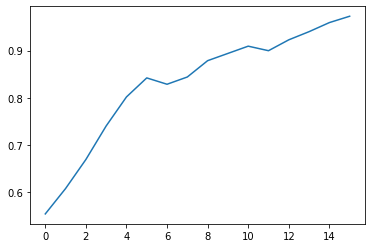

In [ ]:
pyplot.plot(history.history['accuracy'])
pyplot.show()

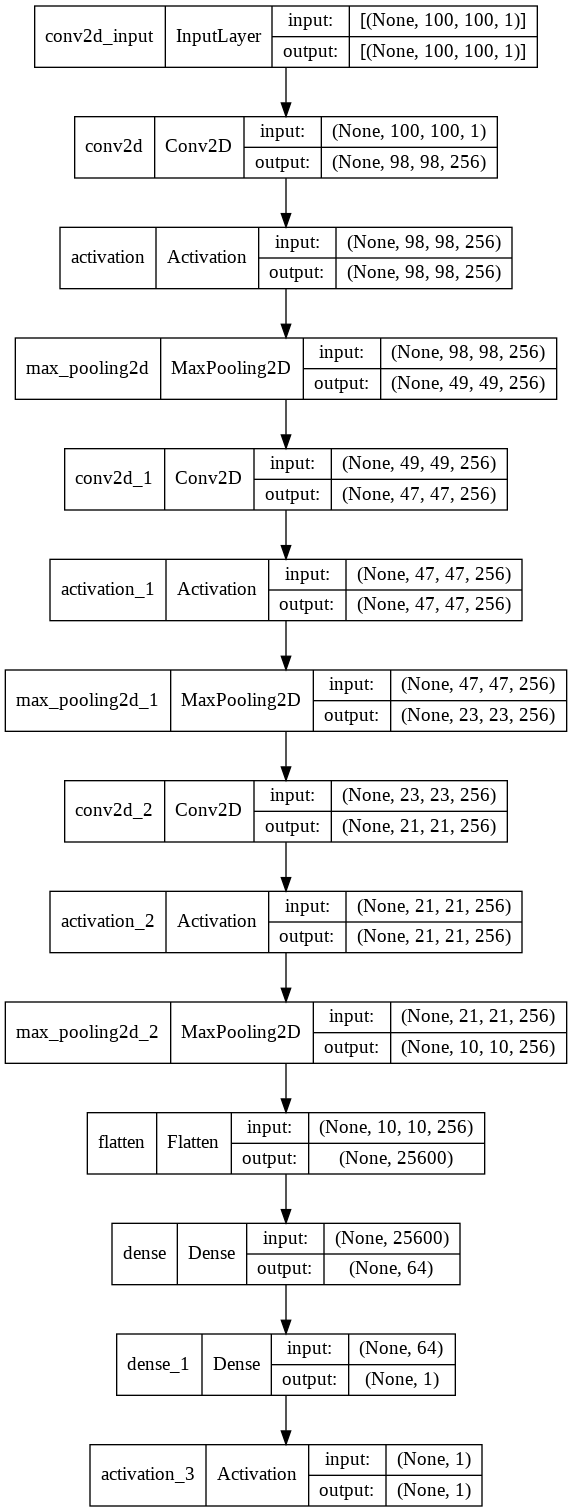

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file='model_with_shapes.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96
)

In [ ]:
model.load('the-folder-where-your-model-located/my_model.tflearn')


IMG_SIZE=100

test_image = cv2.resize(cv2.imread("/content/drive/MyDrive/Colab Notebooks/DATSET/x/t61 (1).jpg", cv2.IMREAD_GRAYSCALE),  (IMG_SIZE,IMG_SIZE))

test_image = np.array(test_image).reshape( -1, IMG_SIZE, IMG_SIZE, 1)

prediction = model.predict({'input': test_image })

NameError: ignored